# Feature Analysis 
Here I will train a sci-kit learn RandomForestRegressor on our events training dataset and evaluate two aspects of the model: feature importances and feature ablation. 

In [1]:
# Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Bring in training and validation data 
training_data = pd.read_parquet('assets/training_set_v2.parquet')
validation_data = pd.read_parquet('assets/validation_set_v2.parquet')

### Standardize data and train model

In [2]:
# Drop unwanted columns
columns_to_drop = ['ItemKey', 'RWB_EFFECTIVE_DATE']
X_train = training_data.drop(columns=['events'] + columns_to_drop, axis=1)
X_val = validation_data.drop(columns=['events'] + columns_to_drop, axis=1)

# Scale the data 
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# Train random forest model
model = RandomForestRegressor()
model.fit(X_train_std, training_data['events'])

# Get top 10 feature importances from sklearn .featureimportances attribute
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
features_outfeat = [X_train.columns[idx] for idx in sorted_indices]
importance_outfeat = [feature_importances[idx] for idx in sorted_indices]
import_feat_df = pd.DataFrame({"Feature": features_outfeat, "Value": importance_outfeat})

### Evaluate feature importance from the `.feature_importances_` method in sklearn

In [3]:
import plotly.express as px

def create_feat_import_bar_chart(data_frame, x_column, y_column, title="Bar Chart"):
    """
    Create a bar chart using Plotly Express.
    """
    sorted_df = data_frame.sort_values(by=y_column, ascending=True)
    fig = px.bar(data_frame, x=x_column, y=y_column, title=title)
    return fig

# Call the function to create the bar chart
bar_chart = create_feat_import_bar_chart(import_feat_df, 
                                         x_column='Value',
                                          y_column='Feature', 
                                          title='Top 10 Feature Importances from RandomForestRegressor')

# Show the chart
bar_chart.show()

### Perform feature ablation analysis 

In [4]:
from sklearn.model_selection import cross_val_score

def peform_feature_ablation(model, X_train, X_train_std):

    # Get the features and feature importances from the 
    # first model run in ascending order
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)
    features_outfeat = [X_train.columns[idx] for idx in sorted_indices]

    # Declare a list of all features 
    train_features = list(X_train.columns)

    mae_scores = []
    num_features = []

    # Train a model with all feautures and assess via cross validation 
    mae_cv = -np.mean(cross_val_score(RandomForestRegressor(), 
                                      X_train_std, 
                                      X_train['events'],
                                      scoring='neg_mean_absolute_error',
                                        cv=5))
    
    mae_scores.append(mae_cv)
    num_features.append(len(train_features))

    # Starting with the lowest feature importance, 
    # remove the feature and assess results via cross validation
    for i, feature in enumerate(features_outfeat):

        # remove the feature from the data 
        remove_ind = train_features.index(feature)
        train_features.remove(feature)

        # Use array slicing and indexing to remove the specified column
        X_train_std = np.delete(X_train_std, remove_ind, axis=1)
        
        # Train a model with all feautures and assess via cross validation 
        mae_cv = -np.mean(cross_val_score(RandomForestRegressor(), 
                                        X_train_std, 
                                        X_train['events'],
                                        scoring='neg_mean_absolute_error',
                                            cv=5))
        
        print(f'completed cross val for {i+1} run(s) of feature ablation')
        
        mae_scores.append(mae_cv)
        num_features.append(len(train_features))

        if len(train_features) == 10:
            break

    ablation_results = pd.DataFrame({"Number_of_Features": num_features,
                                     "CV_MAE": mae_scores})
        
    return ablation_results

abla_df = peform_feature_ablation(model, training_data, X_train_std)
abla_df.to_excel('assets/ablation_results.xlsx', index= False)

completed cross val for 1 run(s) of feature ablation
completed cross val for 2 run(s) of feature ablation
completed cross val for 3 run(s) of feature ablation
completed cross val for 4 run(s) of feature ablation
completed cross val for 5 run(s) of feature ablation
completed cross val for 6 run(s) of feature ablation
completed cross val for 7 run(s) of feature ablation
completed cross val for 8 run(s) of feature ablation
completed cross val for 9 run(s) of feature ablation
completed cross val for 10 run(s) of feature ablation
completed cross val for 11 run(s) of feature ablation
completed cross val for 12 run(s) of feature ablation
completed cross val for 13 run(s) of feature ablation
completed cross val for 14 run(s) of feature ablation
completed cross val for 15 run(s) of feature ablation
completed cross val for 16 run(s) of feature ablation
completed cross val for 17 run(s) of feature ablation
completed cross val for 18 run(s) of feature ablation
completed cross val for 19 run(s) of 

In [10]:
def visualize_ablation_results(in_df, baseline):

    in_df['diff_mae'] = in_df['CV_MAE'] - baseline

    fig = px.line(in_df, x='Number_of_Features', y='diff_mae', title='Random forest feature ablation results from 5-fold cross validation')
    fig.update_xaxes(title_text='Number_of_Features')
    fig.update_yaxes(title_text='Change in Baseline Mean Absolute Error')
    
    return fig

visualize_ablation_results(abla_df, 1.355545)

### Retrain model on top 10 features, get SHAP feature importances 
! warning ! this takes ~9 hours to run.

In [9]:
# Get top 10 important features 
feat_df = pd.read_excel('assets/feature_importances_valrun1.xlsx')
ran_feat_df = feat_df[feat_df['model'] == 'Random Forest Regression']
top_ten_feat = [feat for i, feat in enumerate(ran_feat_df['feature']) if i<10]

# Drop unwanted columns
columns_to_drop = ['ItemKey', 'RWB_EFFECTIVE_DATE']
X_train = training_data.drop(columns=['events'] + columns_to_drop, axis=1)
X_train = X_train[top_ten_feat]
X_val = validation_data.drop(columns=['events'] + columns_to_drop, axis=1)
X_val = X_val[top_ten_feat]

# Scale the data 
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# Train random forest model
model = RandomForestRegressor()
model.fit(X_train_std, training_data['events'])

RandomForestRegressor()

### What is the MSE and RMSE of the model trained on only the top 10 features?

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions_test = model.predict(X_val_std)

# Round predictions (can't have 0.5 number of incidents)
predictions_test = np.round(predictions_test)

mse_test = mean_squared_error(validation_data['events'], predictions_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(validation_data['events'], predictions_test)
print(f'RMSE: {rmse_test} \n MAE: {mae_test}')

RMSE: 1.6318878575357574 
 MAE: 1.1691927476324826


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


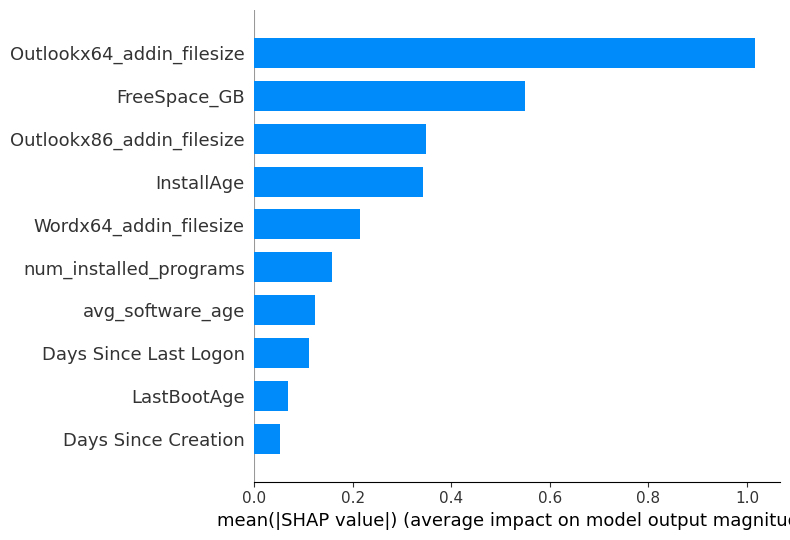

In [10]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


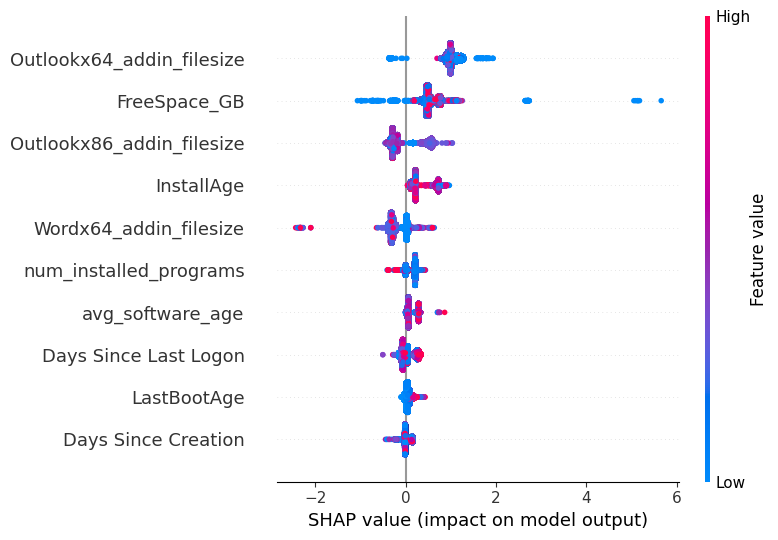

In [17]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

In [23]:
print(X_train.columns)

Index(['Days Since Creation', 'avg_software_age', 'FreeSpace_GB',
       'Outlookx86_addin_filesize', 'Wordx64_addin_filesize',
       'Days Since Last Logon', 'num_installed_programs',
       'Outlookx64_addin_filesize', 'InstallAge', 'LastBootAge'],
      dtype='object')


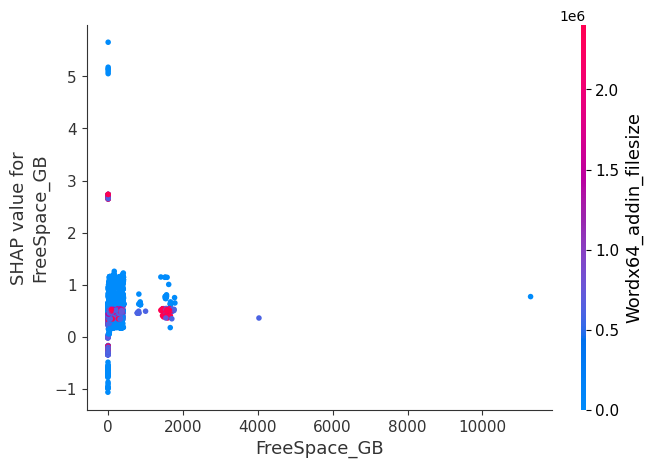

In [49]:
shap.dependence_plot("FreeSpace_GB", shap_values, X_train)